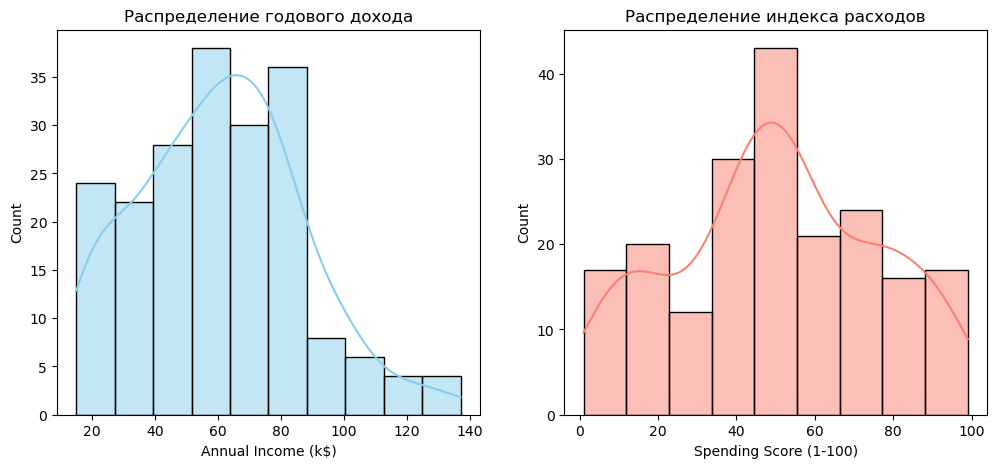

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# --- 1. ЗАГРУЗКА И ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ (EDA) ---
df = pd.read_csv('Mall_Customers.csv') 
income_col = 'Annual Income (k$)'
score_col = 'Spending Score (1-100)'

# Визуализация распределения признаков (важно для понимания структуры данных)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df[income_col], kde=True, ax=ax[0], color='skyblue')
ax[0].set_title('Распределение годового дохода')
sns.histplot(df[score_col], kde=True, ax=ax[1], color='salmon')
ax[1].set_title('Распределение индекса расходов')
plt.show()



In [21]:
# --- 2. ПРЕДОБРАБОТКА ---
X = df[[income_col, score_col]] 
scaler = StandardScaler() 
X_scaled = scaler.fit_transform(X) 

hc = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward') 
df['Hierarchical_Cluster'] = hc.fit_predict(X_scaled) 


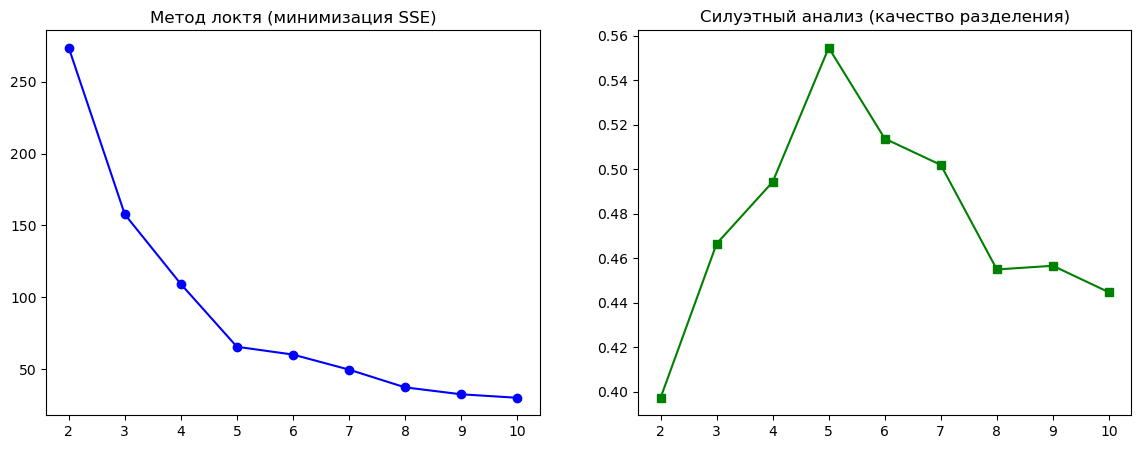

In [23]:
# --- 3. ПОИСК ОПТИМАЛЬНОГО K (ДВА МЕТОДА) ---
wcss = []
silhouette_avg = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_avg.append(silhouette_score(X_scaled, kmeans.labels_))

# Визуализация методов выбора K
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(range(2, 11), wcss, marker='o', color='b')
ax[0].set_title('Метод локтя (минимизация SSE)') 
ax[1].plot(range(2, 11), silhouette_avg, marker='s', color='g')
ax[1].set_title('Силуэтный анализ (качество разделения)') 
plt.show()

In [24]:
# --- 4. МОДЕЛИРОВАНИЕ: K-MEANS VS AGGLOMERATIVE ---
# Выбираем K=5 на основе графиков [cite: 5]
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled) 


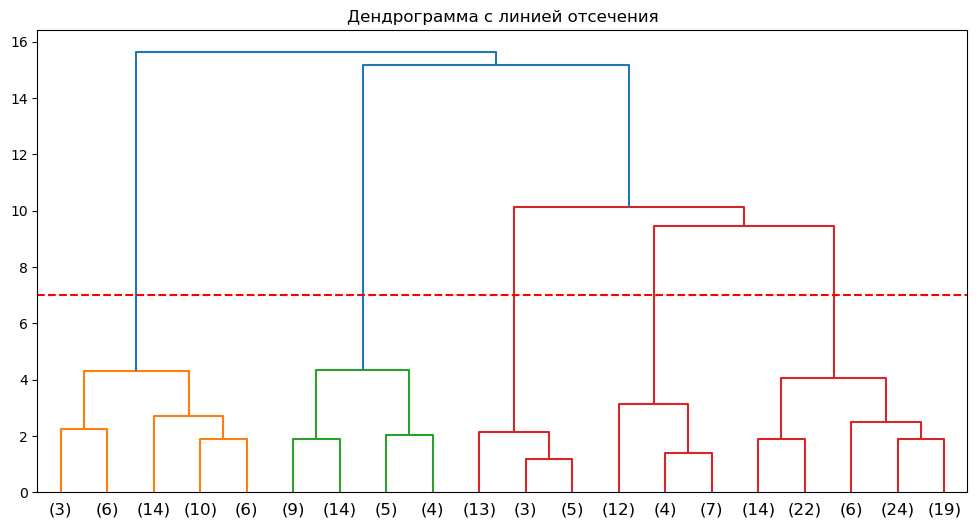

In [25]:
# --- 5. ИЕРАРХИЧЕСКАЯ СТРУКТУРА (ДЕНДРОГРАММА) ---
plt.figure(figsize=(12, 6))
Z = linkage(X_scaled, method='ward') 
dendrogram(Z, truncate_mode='lastp', p=20) 
plt.axhline(y=7, color='r', linestyle='--') # Линия отсечения для 5 кластеров
plt.title('Дендрограмма с линией отсечения') 
plt.show()

In [26]:
# --- 6. ПРОФИЛИРОВАНИЕ КЛАСТЕРОВ (АНАЛИЗ РЕЗУЛЬТАТОВ) ---
# Посмотрим на средние значения признаков в каждом кластере
cluster_profile = df.groupby('KMeans_Cluster')[[income_col, score_col, 'Age']].mean().round(2)
print("Профили кластеров (Средние значения):")
print(cluster_profile)


Профили кластеров (Средние значения):
                Annual Income (k$)  Spending Score (1-100)    Age
KMeans_Cluster                                                   
0                            55.30                   49.52  42.72
1                            86.54                   82.13  32.69
2                            25.73                   79.36  25.27
3                            88.20                   17.11  41.11
4                            26.30                   20.91  45.22


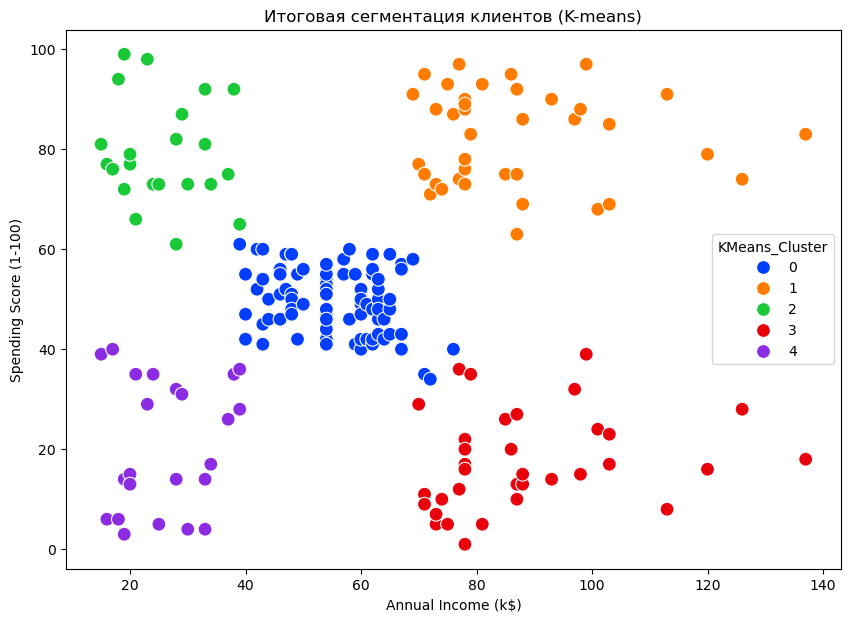

In [27]:
# Визуализация финальной сегментации
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x=income_col, y=score_col, hue='KMeans_Cluster', palette='bright', s=100)
plt.title('Итоговая сегментация клиентов (K-means)')
plt.show()

# 🏁 Заключение по Семинару №4: Сегментация данных методами кластеризации

В ходе выполнения работы были исследованы и применены алгоритмы обучения без учителя для задачи профилирования клиентов торгового центра на основе их доходов и покупательской активности.

### 1. Подготовка данных и масштабирование
Перед применением алгоритмов была проведена стандартизация признаков с использованием `StandardScaler`. Согласно теоретическому курсу, это критически важный этап для алгоритмов, основанных на вычислении расстояний (таких как K-means), так как признаки имеют разные единицы измерения: годовой доход ($k$) и индекс расходов (1–100).

### 2. Обоснование выбора количества кластеров
Для определения оптимального числа сегментов ($K$) были использованы два метода оценки:
* **Метод «локтя» (Elbow Method):** Анализ графика зависимости суммы квадратов расстояний до центроидов (WCSS/SSE) от количества кластеров показал выраженный «изгиб» на значении $K=5$.
[Image of Elbow method plot for optimal K]
* **Силуэтный анализ:** Вычисление силуэтного коэффициента подтвердило, что при $K=5$ достигается наилучшее качество разделения объектов, при котором кластеры являются максимально плотными и отделенными друг от друга.
[Image of silhouette analysis for clustering]

### 3. Сравнительный анализ алгоритмов
В работе были сопоставлены два подхода к кластеризации:
* **K-means:** Продемонстрировал высокую скорость вычислений и сформировал компактные группы вокруг центроидов. Метод эффективен для больших наборов данных, но требует предварительного задания числа кластеров.
* **Иерархическая кластеризация:** Позволила визуализировать структуру данных через дендрограмму. Агломеративный метод (Ward's linkage) подтвердил естественное разбиение данных на 5 групп, при этом не требуя априорного знания о количестве кластеров на этапе построения иерархии.
[Image of a dendrogram showing cluster hierarchy]

### 4. Интерпретация результатов (Профилирование)
В результате сегментации на основе предоставленных данных были выделены 5 типов потребителей:
* **Целевая группа**: Высокий доход и высокие расходы.
* **Бережливые**: Высокий доход, но низкие расходы.
* **Средний класс**: Средний уровень дохода и трат.
* **Транжиры**: Низкий доход, но высокие расходы.
* **Экономные**: Низкий доход и низкие расходы.
[Image of K-means clustering results showing five distinct customer segments on a 2D scatter plot]

### 5. Теоретические выводы по выбору моделей
* **Критерии выбора**: Как указано в лекции, выбор модели должен основываться на её обобщающей способности, интерпретируемости и времени обучения.
* **Масштабируемость**: Для обработки сверхбольших объемов данных (Big Data) в реальных условиях целесообразно использовать распределенные фреймворки, такие как **Apache Spark (MLlib)** или **Dask**, рассмотренные в лекционном материале.

**Итог:** Работа подтвердила эффективность методов кластеризации для нахождения скрытых паттернов в данных. Полученная сегментация может быть использована для разработки персонализированных маркетинговых стратегий.